# Classifying CIFAR10 images using a ResNet and Regularization techniques in PyTorch
### AKA Train an image classifier from scratch to over 90% accuracy in less than 10 minutes

This notebook is an extension to the tutorial [**Image Classification using CNNs in PyTorch**](https://jovian.ml/aakashns/05-cifar10-cnn), where we trained a deep convolutional neural network to classify images from the CIFAR10 dataset with around 55% accuracy. In this tutorial, we'll use the following techniques to achieve over 90% accuracy in less than 10 minutes:
* Data normalization
* Data augmentation
* Residual connections
* Batch normalization
* Learning rate annealing
* Weight Decay
* Gradient clipping

## Preparing the Data
Let's begin by creating PyTorch datasets to load the data, just as we did in the previous tutorial.

In [7]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

There are a few of important changes we'll make while creating the PyTorch datasets:

1. Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set. This just gives a little more data to train with.

2. We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

3. We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

<img src="https://imgaug.readthedocs.io/en/latest/_images/cropandpad_percent.jpg">

In [8]:
data_dir = './data/cifar10'

# Data transforms (normalization and data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                                       tt.RandomHorizontalFlip(),
                                       # tt.RandomRotate
                                       # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1,1)),
                                       # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
                                       tt.ToTensor(),
                                       tt.Normalize(*stats, inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [9]:
# Pytorch Datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

Next, we can create data loaders for retrieving images in batches.

In [10]:
batch_size = 256

# Pytorch Data Loaders

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)

Let's take a look at some sample images form the training dataloader. To display the images, we'll need to denormalize the pixels values to bring them back into the range `(0,1)`.

In [11]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1,2,0).clamp(0,1))
        break

/home/invinci/Me/Deep Learning/DL-env/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


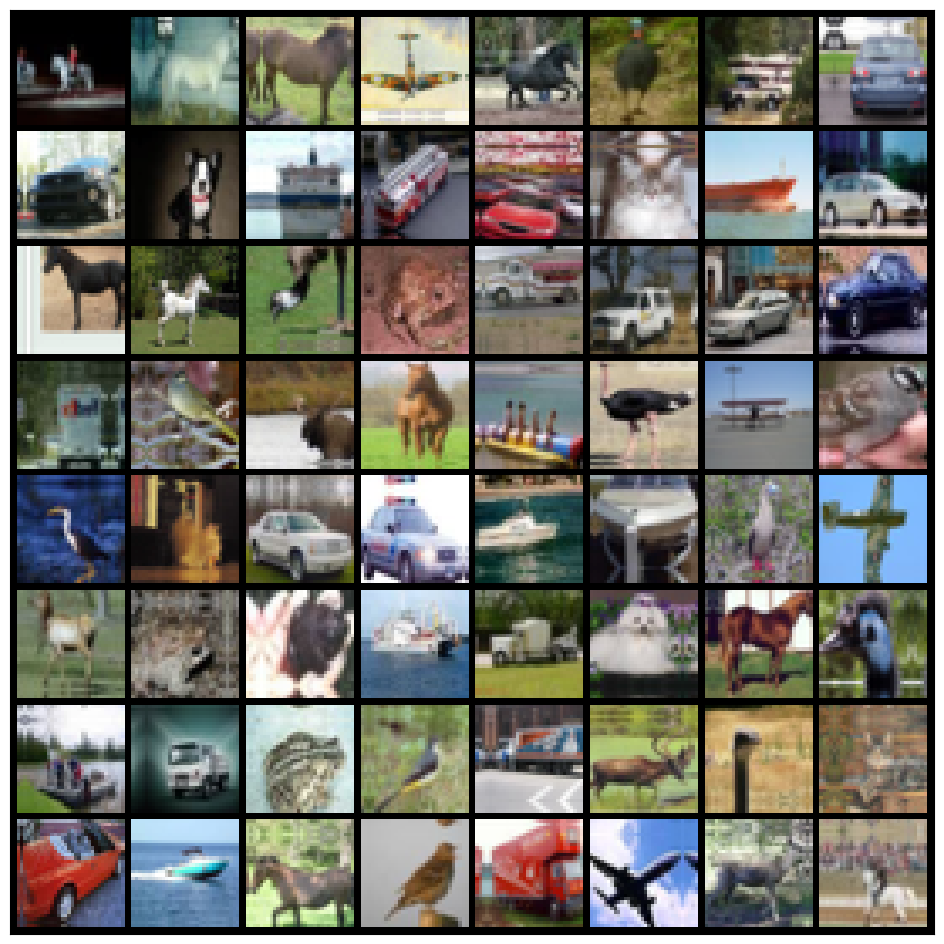

In [12]:
show_batch(train_dl)

The colors seem out of place because of the normalization. Note that normalization is also applied during inference. If you look closely, you can see the cropping and reflection padding in some of the images. Horizontal flip is a bit difficult to detect from visual inspection.

## Model with Residual Blocks and Batch Normalization

We'll use a significatly larger model this time, called the WideResNet22, which has 22 convolutional layers. However, one of the key changes to our model is the addition of the **resudial block**, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

<img src="https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png">

Here is a very simply Residual block:

In [13]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x  # ReLU can applied before or after adding the inputs


To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required. These are described in more detail in the [previous tutorial](https://jovian.ml/aakashns/04-feedforward-nn#C21).

In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
# Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

device = get_default_device()
device

# We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available), and use `to_device` to move our model to the GPU (if available).

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)


# Only Run GPU related in Colab

In [16]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    print(images.shape)
    out = simple_resnet(images)
    print(out.shape)
    break

del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([256, 3, 32, 32])
torch.Size([256, 3, 32, 32])


This seeming small change produces a drastic improvement in the performance of the model. Here's a great blog post explaining why and how residual blocks work: https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec .

Also, after each convolutional layer, we'll add a batch normalization layer. Here's a good explanation of batch normalization: https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd


We will use the ResNet9 architecture. 




TIP:
- Machine learning/deep learning is such a fast evolving field that anything you learn today is likely to be slightly outdated in a year or 2 and there may be new developments in the field which you should be aware of. So It's important to cultivate the habit of reading blogposts, reading papers if possible, reading code, reading tutorials online to be updated. 

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                      # Generate Predictions
        loss = F.cross_entropy(out, labels)     # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                      # Generate Predictions
        loss = F.cross_entropy(out, labels)     # Calculate loss
        acc = accuracy(out, labels)             # Calculate accuracy
        return {'val_loss':loss.detach(), 'val_acc':acc}
    
    def validation_epoch_end(self, outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()  # Combine loss
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()   # Combine accuracies
        return {'val_loss':epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [18]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # 3 x 32 x 32
        self.conv1 = conv_block(in_channels, 64)            # 64 x 32 x 32
        self.conv2 = conv_block(64, 128, pool=True)         # 128 x 16 x 16
        self.res1 = nn.Sequential(conv_block(128,128),      # 128 x 16 x 16
                                  conv_block(128,128))
        
        self.conv3 = conv_block(128, 256, pool=True)        # 256 x 8 x 8
        self.conv4 = conv_block(256,512, pool=True)         # 512 x 4 x 4
        self.res2 = nn.Sequential(conv_block(512, 512),     # 512 x 4 x 4 
                                  conv_block(512,512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),    # 512 x 1 x 1
                                        nn.Flatten(),       # 512
                                        nn.Dropout(0.2),    
                                        nn.Linear(512, num_classes)) # 10 (num_classes = 10)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [19]:
model = to_device(ResNet9(3,10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

Batch normalization and dropout are very interesting techniques used in training a model, there has been a lot of research gone into them. Spend some time reading about them from the link above or anywhere else about `Why` it works? , `How` it works? , `How` it was discovered? and `When` to apply it ?

#### Training the Model

Before we train the model, we're going to make a bunch of small important improvements to our `fit` function:

- `Learning rate scheduling`: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batchof training. There are many strategies for varying the learning rate during training, and the one we'll use is called the `"One Cycle Learning Rate Policy"`, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. Learn more: https://sgugger.github.io/the-1cycle-policy.html 

- `Weight Decay`: We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function. Learn More: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

- `Gradient Clipping`: Apart from the layer weights and outputs, it also helpfulto limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. 

Let's define a `fit_one_cycle` function to incorporate these changes. We'll also record the learning rate used for each batch.


In [27]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient Clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation Phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [21]:
history = [evaluate(model, valid_dl)]
history

KeyboardInterrupt: 

We're now ready to train our model. Instead of SGD (stochastic gradient descent), we'll use the Adam optimizer which uses technique like momentum and adaptive learning rate for learning faster. You can learn more about optimizers here: https://ruder.io/optimizing-gradient-descent

In [22]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam


In [ ]:
%%time

history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                        grad_clip=grad_clip,
                        weight_decay=weight_decay,
                        opt_func=opt_func)

In [ ]:
# Train the model on Colab and note it down here
train_time = '4:21'

Our model trained to over 90% accuracy in under 5 minutes! Try playing around with data augmentations, network architecture & hyperparameters to achieve the following results:
- 94% accuracy in under 10 minutes (easy)
- 90% accuracy in under 2.5 minutes (medium)
- 94% accuracy in under 5 minutes (hard)  

Let's plot the validation set accuracies to study how the model improves over time.


In [28]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    

In [ ]:
plot_accuracies(history)

We can also plot the training and validation losses to study the trend.

In [29]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs No. of epochs')

In [ ]:
plot_losses(history)

It's clear from the trend that our model isn't overfitting to the training data just yet. Try removing batch normalization, data augmentation and residual layers one by one to study their effect on overfitting. Finally let's visualize how the learning rate changed over time, batch-by-batch over all the epochs.

In [30]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

In [ ]:
plot_lrs(history)

As expected, the learning rate starts at a low value, and gradually increasing for 30% of the iterations to a maximum value of `0.01`, and then gradually decreases to a very small value.

#### Testing with Individual Images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test our model with some images from the predefined test dataset of 10000 images.

In [32]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get Predictions from model
    yb = model(xb)
    # Pick index with highest probabilty 
    _, preds = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]


In [ ]:
# Just change the number for image and try out multiple times

img, label = valid_ds[0]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('Label:', train_ds.classes[label], 'Predicted: ', predict_image(img, model))

In [ ]:
img, label = valid_ds[1993]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('Label:', train_ds.classes[label], 'Predicted: ', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hyperparameters.

#### Summary and Further Reading

You are now ready to train state-of-the-art deep learning models from scratch. Try working on a project on your own by following these guidelines: https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/assignment/course-project

Here's a summary of the different techniques used in this tutorial to improve our model performance and reduce the training time:
- `Data Normalization`: We normalized the image tensors by subtracting the mean and dividing by the standard deviation of pixels across each channel. Normalizing the data prevents the pixel values from any one channel from disproportionately affecting the losses and gradients.

- `Data Augmentation`: We applied random transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability.

- `Residual connections`: One of the key changes to our CNN model was the addition of the residual block, which adds the original input back to the output feature map obtained by passing through the input through one or more convolutional layers. We used the ResNet9 architecture.

- `Batch normalization`: After each convolutional layer, we added a batch normalization layer, which normalizes the outputs of the previous layer. This is somewhat similar to data normalization, except it's applied to the outputs of a layer, and the mean and standard deviation are learned parameters.

- `Learning rate scheduling`: Instead of using fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and we used the "One Cycle Learning Rate Policy".

- `Weight Decay`: We added weight decay to the optimizer , yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.

- `Gradient Clipping`: We also added gradient clipping, which helps limit the values of gradients to a small range to prevent undesirable changes in model parameters due to large gradient values during training.

As an exercise, you should try applying each technique independently and see how much each one affects the performance and training time. As you try different experiments, you will start to cultivate the intuition for picking the right architectures, data augmentation & regularization techniques.